# Titanic ensemble modeling classifier

30/7/2021
* [**1. Introduction**](#1)
  * [1.1 Import library](#1.1)
  * [1.2 Loading data](#1.2)
* [**2. Getting familiar with data (Data analysis)**](#2) 
  * [2.1 Missing value](#2.1)
     * [2.1.1 Age](#2.1.1)
     * [2.1.2 Embarked](#2.1.2)
     * [2.1.3 Fare](#2.1.3)
     * [2.1.4 Cabin](#2.1.4)
  * [2.2 Visualization](#2.2)
     * [2.2.1 Visualize percentage of passengers based on "Deck" and "Pclass" features](#2.2.1)
     * [2.2.2 Visualize survival percentage in each "Deck" feature](#2.2.2)
  * [2.3 Target column distribution](#2.3)
  * [2.4 Correlations](#2.4)
  * [2.5 Categorical features](#2.5)
  * [2.6 Remark](#2.6)
* [**3. Feature engineer**](#3)
  * [3.1 Binning Coutinuous features](#3.1)
     * [3.1.1 Fare](#3.1.1)
     * [3.1.2 Age](#3.1.2)
  * [3.2 Frequency Encoded Binning](#3.2)
     * [3.2.1 Family size](#3.2.1)
     * [3.2.2 Ticket frequency](#3.2.2)
  * [3.3 Title & is Married](#3.3)
  * [3.4 Feature transformation](#3.4)
     * [3.4.1 Label encoding non-numerical features](#3.4.1)
     * [3.4.2 One-hot encoding the categorical features](#3.4.2)
* [**4. Modeling**](#4)
  * [4.1 Cross validation simple models](#4.1)
  * [4.2 Hyper parameters tunning](#4.2)
  * [4.3 Confusion matrix](#4.3)
  * [4.4 Ensemble model](#4.4)
  * [4.5 Submission](#4.5)

<a name='1'></a>
# 1. Introduction
This project is on the titanic which was on 14 April 1912. Before it was colliding with an ice berg and ended up at the bottom of the Alantic sea. She was the biggest moveable object at the time. She was call "unsinkable". Which was not true. Over a thousand people died in the icy sea that night

<img src="images/titanic_intro.jpg" style="width:500px;height:300px;">

*By the end of this notebook, we'll go through*
* **Data analysis** 
    * (Missing value, data visualization, correlation table, categorical features)
* **Feature engineering** 
    * (Binning continuous features, Frequency encoded binning, Feature transformation)
* **Modeling** 
    * (Cross validation technique, Hyper parameter tunning, Confusion matrix)

<a name='1.1'></a>
## 1.1 Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV
SEED = 42

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

import warnings
import time
warnings.filterwarnings('ignore')

<a name='1.2'></a>
## 1.2 Loading data
- Training set has 891 rows, testing set has 418 rows
- There are 12 features in training set and 11 features in testing set
- One extra feature in training set is "Survived" which is the target feature

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print(f'Number of Training Examples = {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}\n')
print(f'Training X Shape = {df_train.shape}')
print(f'Training y Shape = {df_train["Survived"].shape[0]}\n')
print(f'Test X Shape = {df_test.shape}')
print(f'Test y Shape = {df_test.shape[0]}\n')
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


<a name='2'></a>
# 2. Getting familiar with data
- **PassengerId** is the unique id of the row and it doesn't have any effect on target
- **Survived** is the target variable we are trying to predict (*0=Not Survived* or *1=Survived*)
- **Pclass** (Passenger class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (*1=Upper Class*, *2=Middle Class* or *3=Lower Class*)
- **Name**, **Sex** and **Age** are self-explantory
- **SipSp** the total number of passenger's siblings and spouses
- **Parch** the total number of passenger's parent and children
- **Ticket** the ticket number of passenger
- **Fare** Passenger's fare
- **Cabin** is the cabin number of passenger
- **Embarked** is port of embarkation and it is a categorical feature which has 3 unique values (*C=Cherbourg*, *Q=Queenstown* or *S=Southampton*)

In [3]:
print(df_train.info())
df_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
print(df_test.info())
df_test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


<a name='2.1'></a>
## 2.1 Missing value
(Which columns contain missing value?)
<br>As we seen below, the *display_missing()* function count number of missing value in each feature of both training and testing dataset
- Columns in training set contained missing value: **Age**, **Cabin**, **Embarked**
- Columns in testing set contained missing value: **Age**, **Fare**, **Cabin**
<br>

**Remark**
- It's more convinient to concatunate training and testing set when dealing with features containing missing value.
- The missing value of "Age", "Embarked" and "fare" is smaller compared to total samples, but roughly 80% of "Cabin" value is missing
- The missing value of "Age", "Embarked" and "fare" can be filled with descriptive statistic (median or mean) but this shouldn't be applied for "Cabin" feature

In [5]:
for df in dfs:
    print(f'Missing values in {df.name}')
    print(df.isnull().sum(), "\n")

Missing values in Training Set
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

Missing values in Test Set
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64 



<a name='2.1.1'></a>
### 2.1.1 Age
- Missing value of "Age" can be filled with median but using median age for the whole dataset is not a good choice. Fristly, we need to figure out which features are highly correlated with "Age" columns
- Based on correlation table, **Pclass** groups is the **best choice** because of its *high correlation* with Age(0.408) --> It's also logical that the passenger class is highly correlated with Age of passenger

(NOTE) .reset_index() can be used to transform to dataframe

In [6]:
# Correlation table between features
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="mergesort", ascending=False).reset_index()
df_all_corr.rename(columns={0:'Correlation'}, inplace=True)
df_all_corr.loc[df_all_corr['level_0'] == 'Age']

,level_0,level_1,Correlation
6,Age,Age,1.000000
10,Age,Pclass,0.408106
18,Age,SibSp,0.243699
22,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
42,Age,PassengerId,0.028814


- **Sex** level can be considered as the second level of groupby while filling the missing value of **Age**
- By looking at the table, the higher the level of Pclass, the higher the median of Age's values & the Age's value of males tends to be higher than those of females

In [7]:
# Fill Age's null val by the median grouped by "Sex" and "Pclass" features
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
df_all.groupby(["Sex", "Pclass"]).median()["Age"].reset_index()

,Sex,Pclass,Age
0,female,1,36.0
1,female,2,28.0
2,female,3,22.0
3,male,1,42.0
4,male,2,29.5
5,male,3,25.0


<a name='2.1.2'></a>
### 2.1.2 Embarked
- There are only 2 missing Embarked's rows in dataset.

How to fill appropriate value to missing pieces?
- When I google "Stone, Mrs. George Nelson (Martha Evelyn)", it results that Mrs.Evelyn was embarked from Southampton (S) port & 2 missing rows have the same ticket number --> The missing piece should be "S"

In [8]:
# Missing value in "Embarked" column
df_all.loc[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [9]:
# Filling Embarked's missing value with S
df_all['Embarked'] = df_all['Embarked'].fillna("S")

<a name='2.1.3'></a>
### 2.1.3 Fare
- Fare is the cost of ticket. There is only 1 missing value in the dataset

--> Just use median of Fare to fill in the missing piece

In [10]:
# Missing value in "Fare" column
df_all.loc[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [11]:
# Fill fare's nan value with median group by "Parch", "SibSp" and "Pclass"
# Nan's fare attribute has "Parch"=0; "Pclass"=3 and "SibSp"=0
med_fare = df_all.Fare.median()
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

<a name='2.1.4'></a>
### 2.1.4 Cabin
- The large portion (nearly 80%) of cabin feature is missing and the feature itself can not be ignored completely because cabin is essential in deciding the survival rate of customers.

--> Therefore, It'd be appropriate to separate all the null cabin values as a cabin "M"

- The Cabin value looks like C123, it turns out the 1st letter represents the deck in which cabin is located.

--> We need to separate the column "Cabin" into the "Deck" column only and the remaining number are redundant (should be removed)

In [12]:
nan_cabin_percent = round(df_all['Cabin'].isnull().mean()*100, 2)
print(f"Proportion of missing values in \"Cabin\" feature is {nan_cabin_percent}%")

Proportion of missing values in "Cabin" feature is 77.46%


In [13]:
# Create col "Deck" contained only 1st letter of column "Cabin" & assign "M" to null
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'X')
df_all['Deck'].value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Deck, dtype: int64

<a name='2.2'></a>
## 2.2 Visualization

<a name='2.2.1'></a>
### 2.2.1 Visualize percentage of passengers based on "Deck" and "Pclass" features

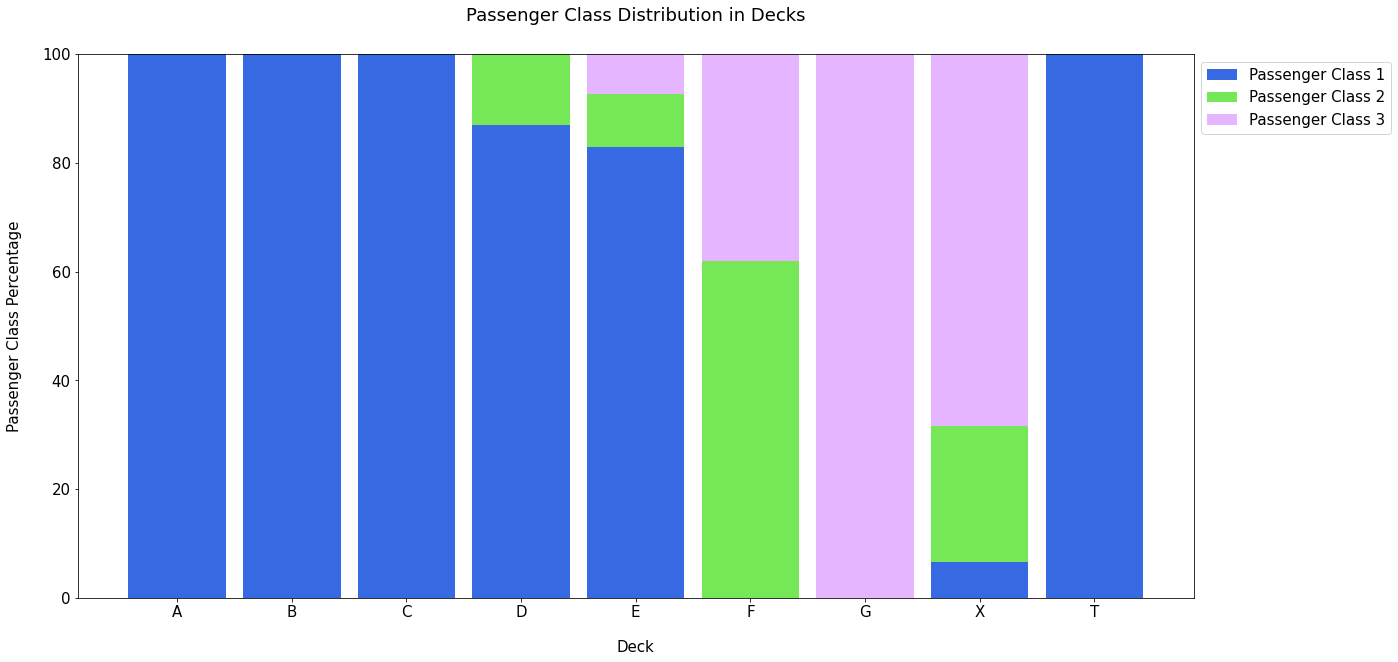

In [14]:
# Count # of passengers based on pair ("Deck", "Pclass")
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

# TODO: Return # of passengers & percentage in each deck groupped by Pclass
def get_pclass_dist(df):
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'X': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages
    

# TODO Visualize Percentage of each class based on each deck
def display_pclass_dist(percentages):
    
    # Visualize preparation
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'X', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    # Apply data to figure
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#376AE2', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#76E857', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#e5b5ff', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

Remarks
- 100% of decks A, B and C are 1st class
- Deck D, 87% is 1st class & 13% is 2nd class
- Deck E, 83% is 1st class, 10% is 2nd class & 7% is 3rd class
- Deck F, 62% is 2nd class & 38% is 3rd class
- Deck G, 100% is 3rd class
- Deck X, 6.6% is 1st class, 25% is 2nd class & 68.4% is 3rd class
- Deck G, 100% is 1st class
- Deck X represents all passengers containing NULL value in "Cabin" column -> Use "X" as the value of Cabin also
- There is only 1 passenger with deck "T" --> Transform deck "T" to "A" because this passengers is in upper class also

In [15]:
# Transform passenger with deck T to A
idx = df_all.loc[df_all['Deck'] == "T"].index
df_all.loc[idx, 'Deck'] = 'A'

<a name='2.2.2'></a>
### 2.2.2 Visualize survival percentage in each "Deck" feature
- The highest percentage of survival rate belongs to decks B, C, D and E. Those decks are almost occuppied by the 1st class passengers. While the rate in decks X is the lowest and all passengers staying in this deck only from 2nd and 3rd class.

--> As a result, Cabin containing the 1st class passengers have a higher rate of survival than the other class. And it makes sense that we don't have cabin's data, where majority of 2nd and 3rd class passengers stayed, just because they were not survived. It's compelling to label them as a unique deck X.

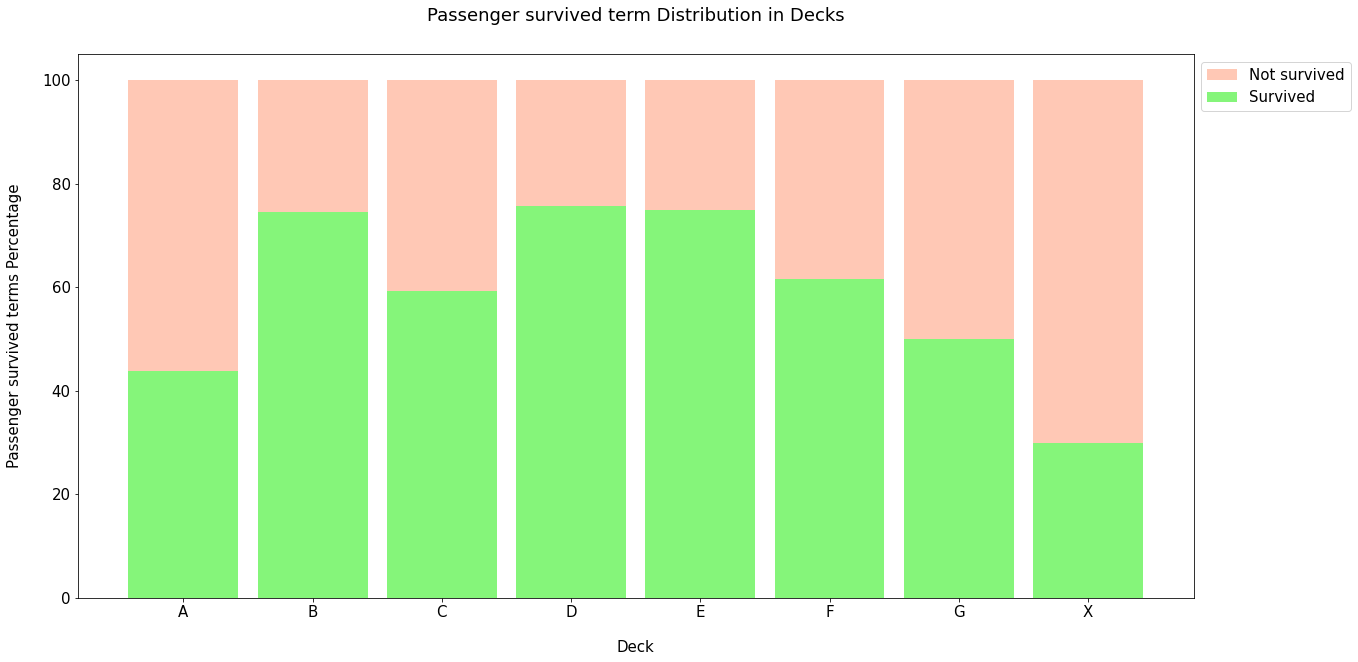

In [16]:
# Count # of passenger grouped by ('Deck' and 'Survived')
df_all_survived = df_all.groupby(["Deck", "Survived"]).count()['Name']

# TODO: Return # of passengers & percentage in each deck based on "Survived" term
def get_survide_dist(df):
    # deck_counts: Count number of survive passengers in each decks
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'X': {}}
    decks = list(deck_counts.keys())  
    
    for deck in decks:
        for survived in range(0, 2):
            try:
                count = df[deck][survived]
                deck_counts[deck][survived] = count 
            except KeyError:
                deck_counts[deck][survived] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # deck_percentages: Survival percentage in each deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

# TODO Visualize Percentage of survived terms based on each deck
def display_survived_dist(percentages):
    
    # Visualize preparation
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'X')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    # Bar's content
    not_survived = df_percentages[0]
    survived = df_percentages[1]
    
    # Apply data to figure
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, bottom=survived, color='#ffc8b5', width=bar_width, label='Not survived')
    plt.bar(bar_count, survived, color='#85f57a', width=bar_width, label='Survived')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger survived terms Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger survived term Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_survide_dist(df_all_survived)
display_survived_dist(all_deck_per)

'Decks' is now a high-cardinality feature -> We'll group decks value based on their similarity
- A, B and C decks are labeled as ABC because all of them have only 1st class passengers
- D and E decks are labeled as DE because both of them have similar passenger class distribution and same survival rate
- F and G decks are labeled as FG because of the same reason above
- M deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

(NFM) "High-cardinality" feature is the feature which is unique and uncommon (too many unique values)

In [17]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

X      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

- Feature "Cabin" will be deleted and replaced by "Deck" feature

In [18]:
# Drop feature Cabin
df_all.drop('Cabin', axis=1, inplace=True)

# Separate training and testing data
df_train, df_test = divide_df(df_all)

print('Missing values in Training dataset')
print(df_train.isnull().sum(), "\n")
print('\n Missing values in Testing dataset')
print(df_test.isnull().sum(), "\n")

Missing values in Training dataset
Age            0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Survived       0
Ticket         0
Deck           0
dtype: int64 


 Missing values in Testing dataset
Age            0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Ticket         0
Deck           0
dtype: int64 



<a name='2.3'></a>
## 2.3 Target column distribution

In [19]:
# Compute survival percentage in training dataset
not_survived = df_train['Survived'].loc[df_train['Survived']==0].count()
survived = df_train['Survived'].loc[df_train['Survived']==1].count()
print(f'{not_survived} of {not_survived+survived} passengers survived and it is the 38.38% of the training set.')
print(f'{survived} of {not_survived+survived} passengers survived and it is the 61.62% of the training set.')

549 of 891 passengers survived and it is the 38.38% of the training set.
342 of 891 passengers survived and it is the 61.62% of the training set.


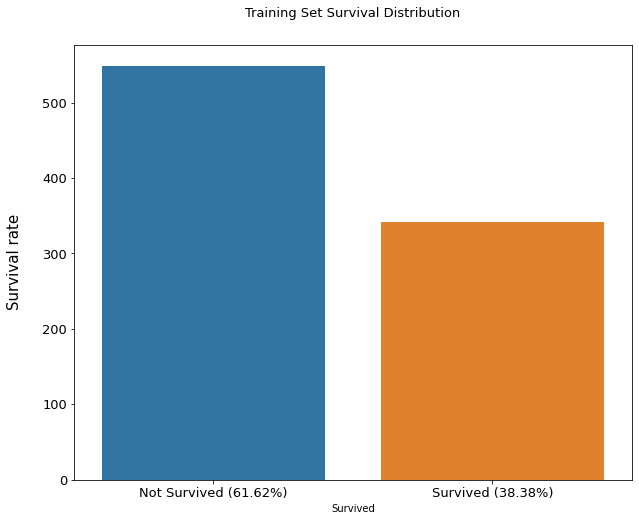

In [20]:
# Visualize number of survival and non_survivals in training dataset
survived_rate = [survived, not_survived]
bar_count = ['Survived', 'Not survived']

plt.figure(figsize=(10, 8))
# plt.bar(bar_count, survived_term, label=['Survived', 'Not survived'], color='#f9bc86', edgecolor='white')
sns.countplot(df_train['Survived'])

plt.ylabel('Survival rate', size=15, labelpad=20)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived/(not_survived+survived)*100),
                    'Survived ({0:.2f}%)'.format(survived/(not_survived+survived)*100)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=13, y=1.05)
plt.show()

- 38.38% survival passengers in training set
- 61.62% not survival passengers in training set

<a name='2.4'></a>
## 2.4 Correlations
- Correlation is a statistical term which in simple explanation refers to how close two variables having linear relationship with each other

For example, 2 variables are linearly dependent (x and y are dependent on each other as x=2y). While 2 variable are independent (# of parents & Pclass are not close to each other)

*(Why negative values exist in correlation table?)*
- It means that there is an inverse relationship between 2 variables tested
- For example, the snowfall-driver is negative correlation b.c the increase the amount of snowfall, the few the number of driver on the street

In [21]:
# Construct correlation table for Training data
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
# Remove odd row's index b.c they're replicated by the even row's index
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
# Drop row having correlation value 1.0
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

# Construct correlation table for Testing data (Steps same as training data)
df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [22]:
temp = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd.loc[temp]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577313
8,Age,Pclass,0.526789
10,Age,Fare,0.346069
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230325
16,SibSp,Fare,0.171912


Text(0.5, 1.0, 'Testing correlation set')

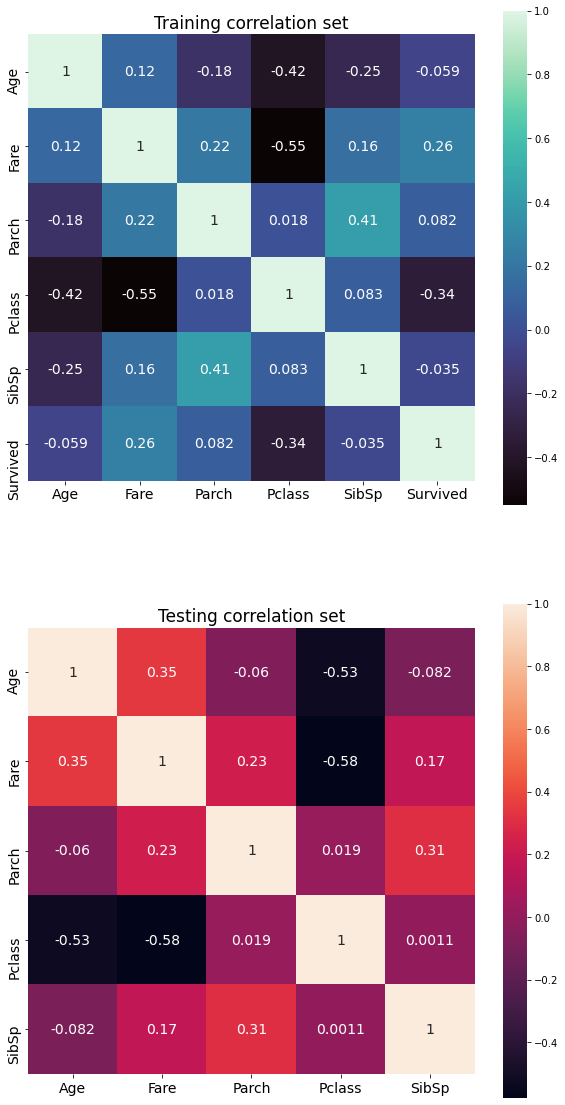

In [23]:
# Visualize correlation table by heatmap
fig, axs = plt.subplots(nrows=2, figsize=(10, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True,
            cmap='mako', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True,
            cmap='rocket', annot_kws={'size': 14})

for i in range(2):
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training correlation set', fontsize=17)
axs[1].set_title('Testing correlation set', fontsize=17)

### Take away from correlation plot
- Following the above plot, there is only few highly correlated features but this signal is a good point. It means that the features don't contain much the redundant or unnecessary values and we're happy that each feature carries with its own unique information. 

<a name='2.5'></a>
## 2.5 Categorical features
- In statistics, a **categorical variable** (also called **qualitative variable**) is a variable that can take on one of a *limited, and usually fixed number of possible values* (Reference link: [here](https://en.wikipedia.org/wiki/Categorical_variable))
- In this situation, List of categorical features: Embarked, Parch, Pclass, Sex, SibSp & Deck

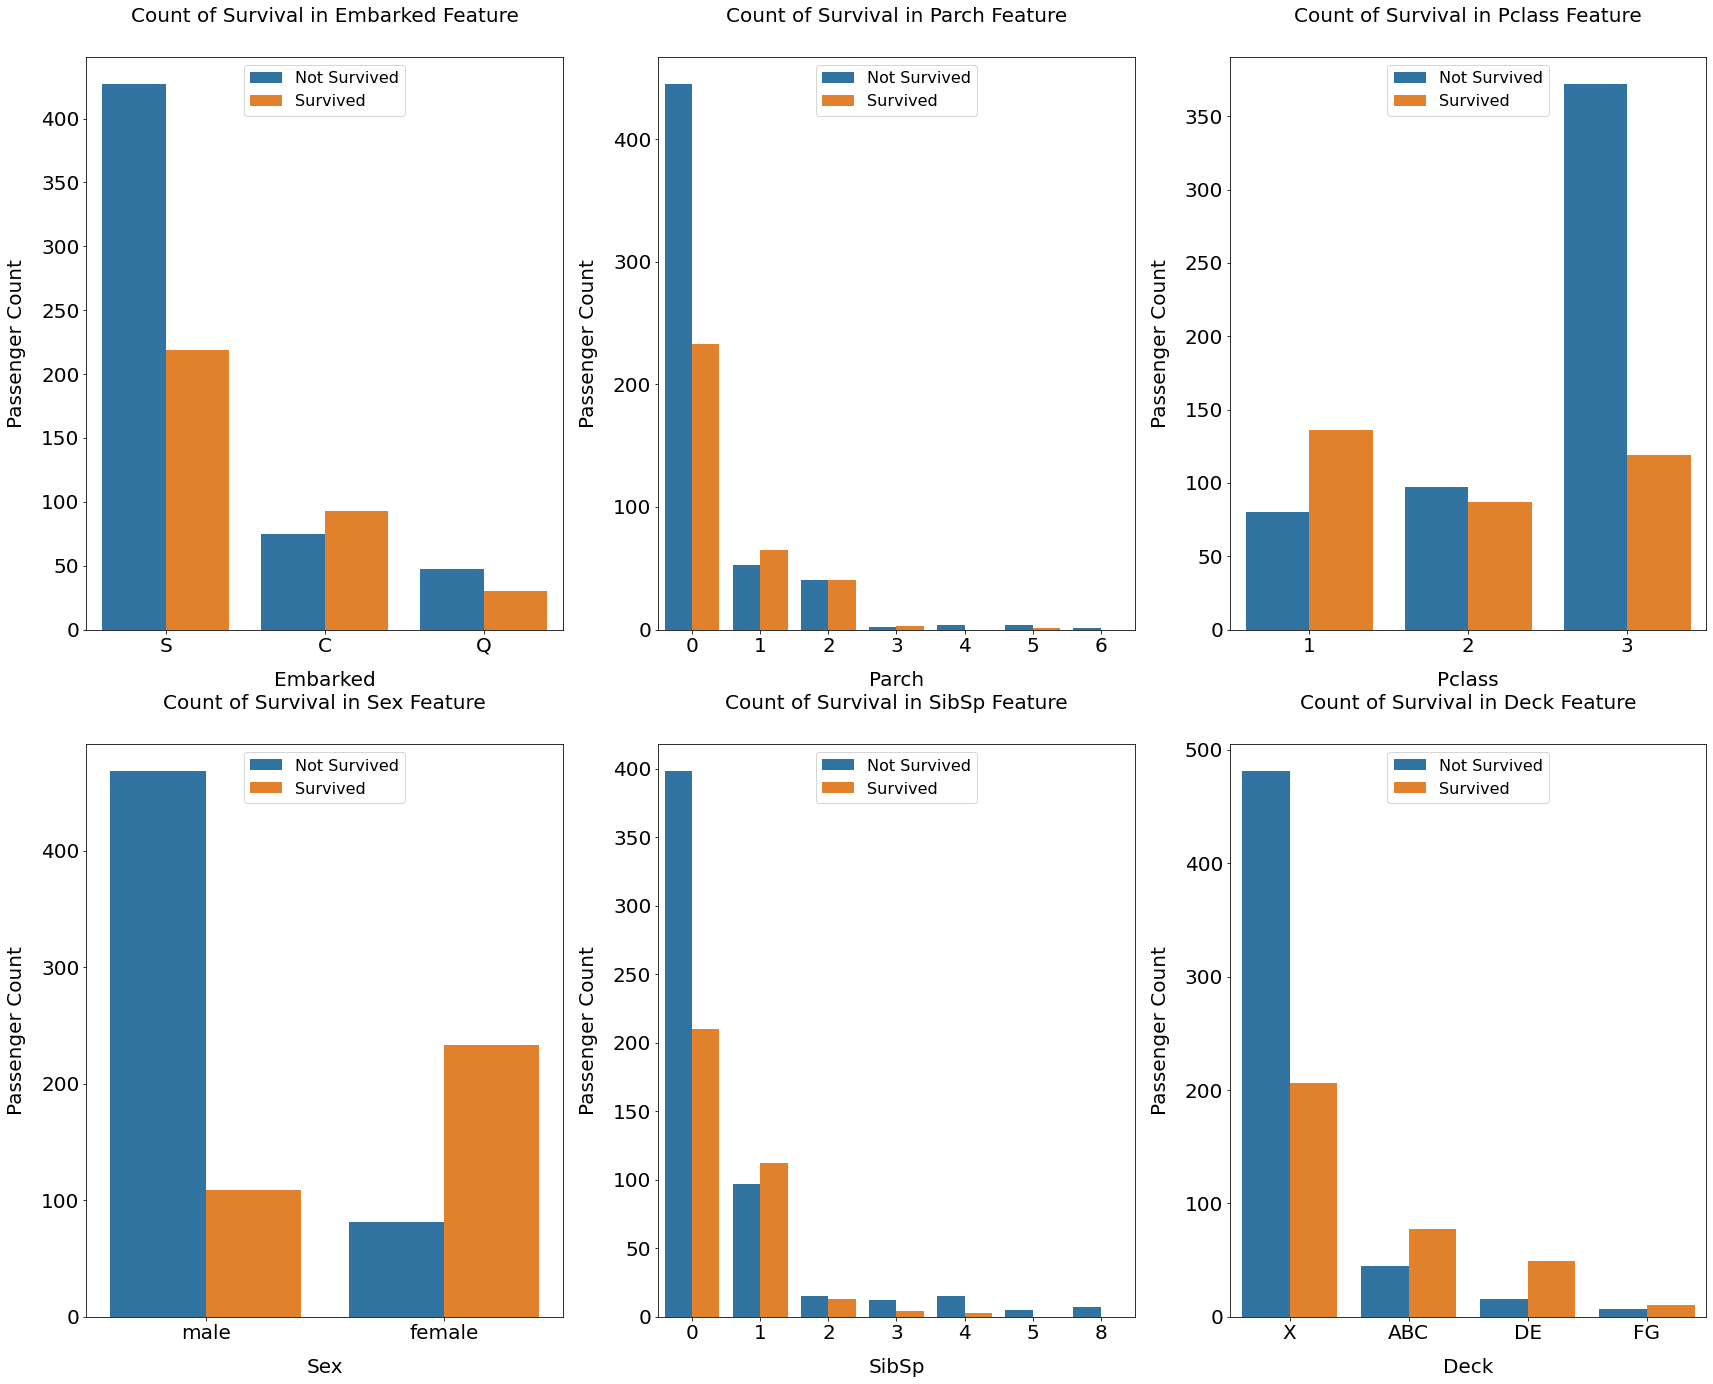

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
cols = {1:'Embarked', 2:'Parch', 3:'Pclass', 4:'Sex', 5:'SibSp', 6:'Deck'}
plt.subplots_adjust(right=1.25, top=1)

# i: 1->6 show position of the plot
for i, feature in cols.items():
    plt.subplot(2, 3, i)
    # Countplot for 2 features
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 16})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)
plt.show()

Every categorical feature has at least 1 class having high mortality rate. Those classes play an important role in figuring out the passenger is a survivor or victim. 
- The passenger boarded from Southampton (S) has a lower survival rate, and they accounted for nearly half the total of passengers. 
- While the number of survived passengers boarded from Cherbourg (C) equals to half or higher the total survivors
- Moreover, decks occupied by almost upper class has higher survival rate than the other & The 1st class also has the highest rate in terms of survival feature
- Female has largely high survival rate than the other gender. The number of survived female is nearly one half bigger than its non-survival rate.

--> Feature 1st class is highly related to the survival term

## Remark
- This relationship can be used to create new features with "feature transformation" and "feature interaction". 
- Target encoding could be very useful as well because of the high correlations with Survived feature.
- Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

In [25]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,X,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,X,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,X,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


<a name='3'></a>
# 3. Feature engineering

<a name='3.1'></a>
## 3.1 Binning Continous features
- Is process of transforming from a continuous or numerical variable to a categorical feature by groupping them into some smaller ranges. We called it "Binning" technique
- Binning of continuous variable is one of feature engineering technique and tends to improve the performance of the model. 
- The binning can be also used to identify missing values or outliers
- This mechanism divived the continuous variable into specific number of bins which is a smaller range out of total range of the numerous feature 

<a name='3.1.1'></a>
### 3.1.1 Fare

In [26]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

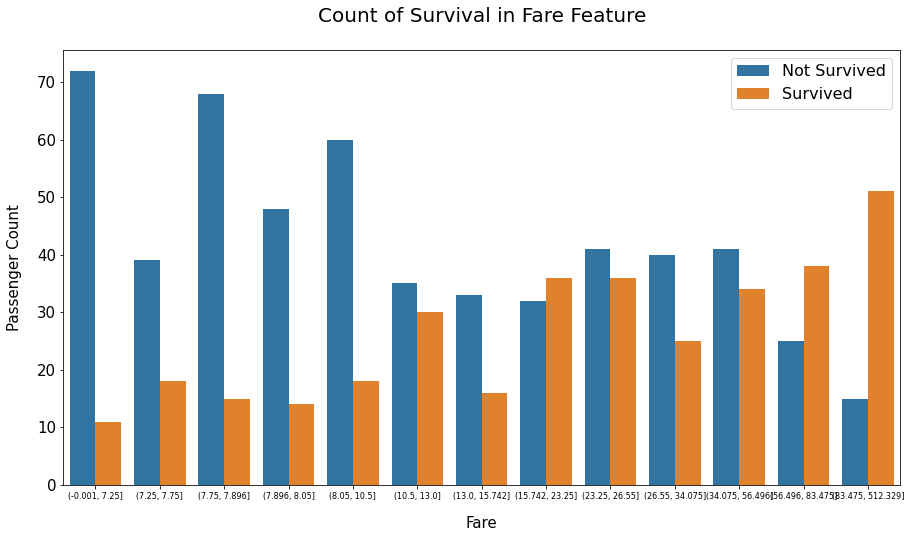

In [27]:
plt.figure(figsize=(15, 8))
# Countplot for 2 features
sns.countplot(x='Fare', hue='Survived', data=df_all)
    
plt.xlabel('Fare', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)    
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=15)
    
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 16})
plt.title('Count of Survival in Fare Feature', size=20, y=1.05)
plt.show()

REMARK
- "Fare" feature and "Survived" rate are negatively correlated with each other
- 13 quantiles based bins are used for 'Fare' feature. They provide a decent amount of information gain
- The group on the left has the lowest survival rate and the group on the right has the highest survival rate
- There is an unusual bin [15.742, 23.25] in the middle of graph which has higher survival rate than the other

<a name='3.1.2'></a>
### 3.1.2 Age

In [28]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

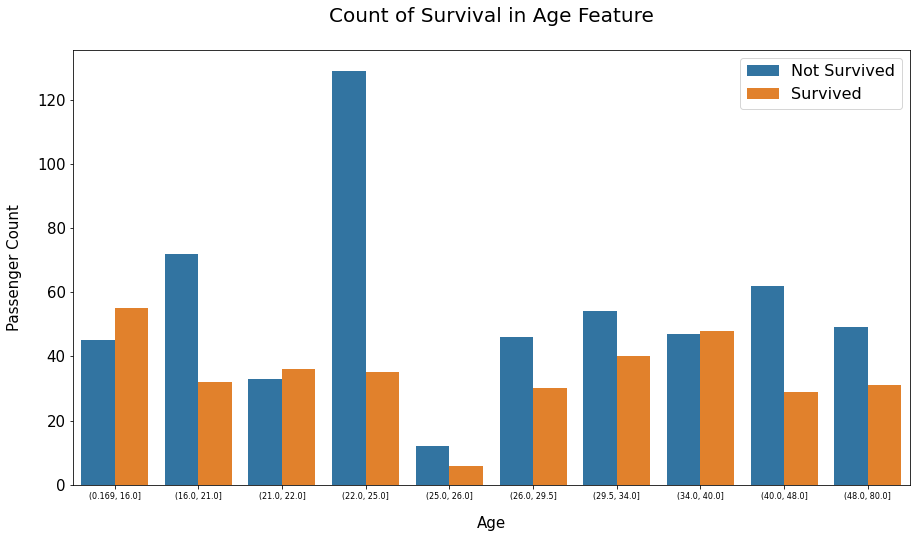

In [29]:
plt.figure(figsize=(15, 8))
# Countplot for 2 features
sns.countplot(x='Age', hue='Survived', data=df_all)
    
plt.xlabel('Age', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)    
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=15)
    
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 16})
plt.title('Count of Survival in Age Feature', size=20, y=1.05)
plt.show()

REMARK
- Passenger with ages ranging from [22.0, 25.0] has by far the most lowest survival rate than the other and bin with [0.169, 16] has the highest survival rate
- There is an age's group [34.0, 40.0] with unusual high survival rate in this process

<a name='3.2'></a>
## 3.2 Frequency Encoded Binning

<a name='3.2.1'></a>
### 3.2.1 Family size
- Family_Size is created by adding SibSp, Parch and 1. 
- Those columns are added to compute the total size of family & 1 is added to the end for current passenger himself/herself. The Family_Size table. Graph also clearly show that `Family_size` is the predictor of survival rate, b.c different size turns out different rate
    
    - Family size with 1 labeled: Alone
    - Family Size with 2, 3 and 4 are labeled as Small
    - Family Size with 5 and 6 are labeled as Medium
    - Family Size with 7, 8 and 11 are labeled as Large
- Because the survival rate is highly effected by whether passenger was alone or not. Therefore, a new feature "Alone" can be considered as a flag for the lonely passengers

In [30]:
# Family_Size feature
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1
# Family_Size_Grouped feature
family_map = {1:'alone', 2:'small', 3:'small', 4:'small', 5:'medium', 6:'medium', 7:'large', 8:'large', 11:'large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)
# Create feature "Alone"
df_all['Alone'] = 0
df_all['Alone'].loc[df_all['Family_Size_Grouped'] == 'alone'] = 1

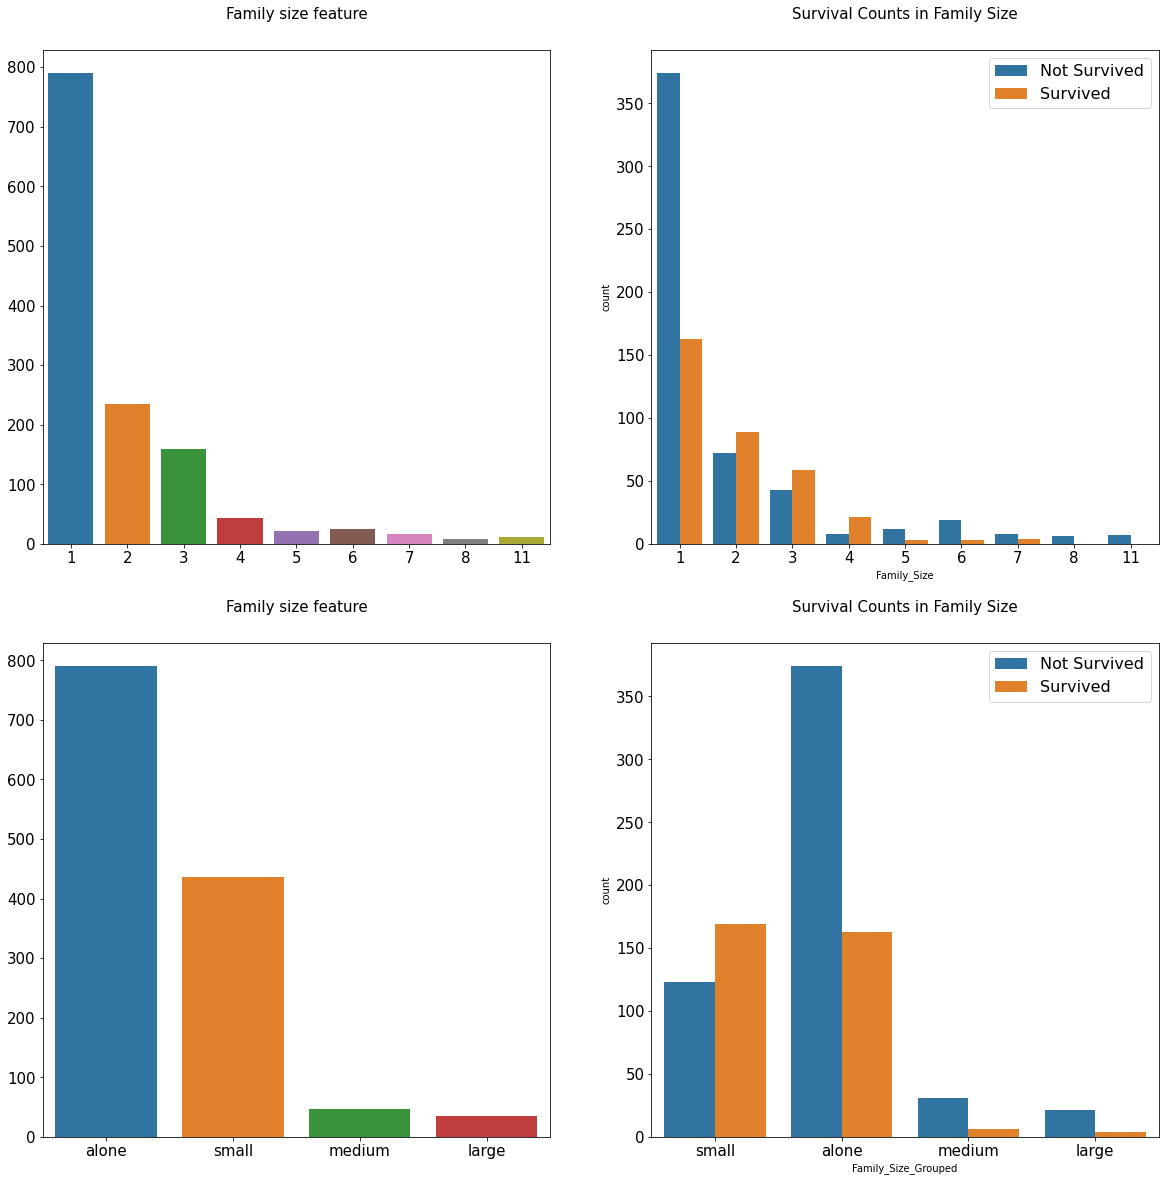

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
cols = {1:'Family_Size', 3:'Family_Size_Grouped'}
# plt.subplots_adjust(right=1.25, top=1)

# i: 1->6 show position of the plot
for i, col in cols.items():
    # Family size summary
    plt.subplot(2, 2, i)
    # Countplot for "Family_Size" feature
    sns.barplot(x=df_all[col].value_counts().index,
                y=df_all[col].value_counts().values)
    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('Family size feature', size=15, y=1.05)
    

    # Family size summary based survival features
    plt.subplot(2, 2, i+1)
    # Countplot for "Family_Size" and "Survived" feature
    sns.countplot(x=col, hue='Survived', data=df_all)
    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 16})
    plt.title('Survival Counts in Family Size', size=15, y=1.05)
plt.show()

<a name='3.2.2'></a>
### 3.2.2 Ticket frequency
- Passengers who're comming with their families or their mates bought the same tickets
- There are too many unique `Ticket` values to analyze, so grouping them up by their frequencies makes things easier.

**How** is this feature difference from `Family_size`?
- Many passengers travel along with groups who **can be their friends, team mates** not necessary be a family. Therefore, they are not counted in `Family_size` but instead using **the same ticket number**

**How** does the family size affect the survival rate?
- According to graph, passengers traveling with group of 2, 3, 4 have the highest survival rate, while those who travel alone has the lowest survival rate. From group of 5 onwards, the survival rate decreases dramatically. 
- The pattern is really similar to `Family_size` feature --> `Ticket_frequency` can be considered as the predictor

In [32]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

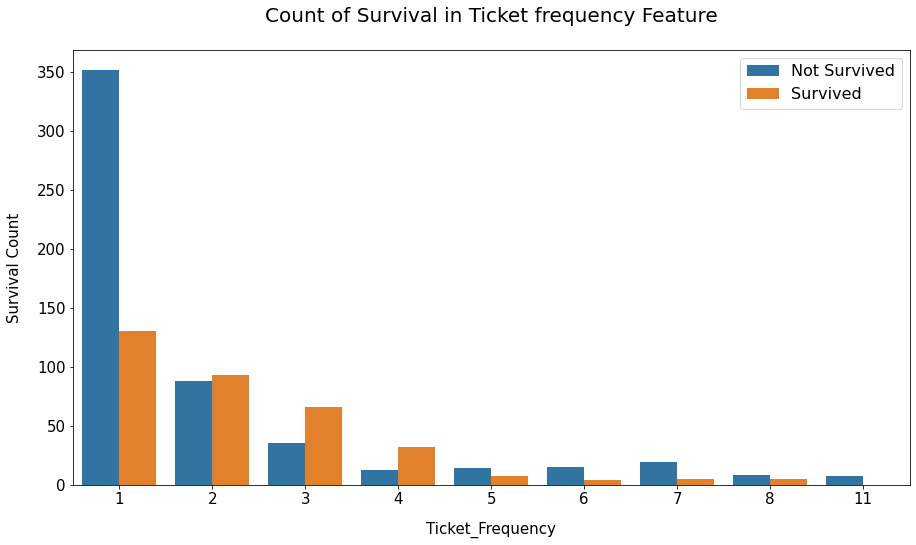

In [33]:
plt.figure(figsize=(15, 8))
# Countplot for 2 features
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)
    
plt.xlabel('Ticket_Frequency', size=15, labelpad=15)
plt.ylabel('Survival Count', size=15, labelpad=15)    
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
    
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 16})
plt.title('Count of Survival in Ticket frequency Feature', size=20, y=1.05)
plt.show()

<a name='3.3'></a>
## 3.3 Title & is Married
- Title is created by extracting the prefix before Name feature. According to graph below, there are many titles that are occuring very few times. 
- Some of those titles doesn't seem correct and they need to be replaced. 
- **Miss, Mrs, Ms, Mlle, Lady, Mme, the Countess, Dona** titles are replaced with Miss/Mrs/Ms because all of them are female. 
- **Dr, Col, Major, Jonkheer, Capt, Sir, Don and Rev** titles are replaced by **Dr/Sir/Noble/Clergy** because those passengers have similar characteristics. 
- **Master** is a unique title. It is given to male passengers below age 26. They have the highest survival rate among all males.

**Is_Married** is a binary feature based on the **Mrs** title. Mrs title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [34]:
df_all['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [35]:
# Extract the tile and Is_married signal from the name
df_all['Title'] = df_all['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0].str.strip()
df_all['Married'] = 0
df_all['Married'].loc[df_all['Title'] == 'Mrs'] = 1

# Title unique values count
df_all['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
the Countess      1
Don               1
Lady              1
Capt              1
Sir               1
Mme               1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

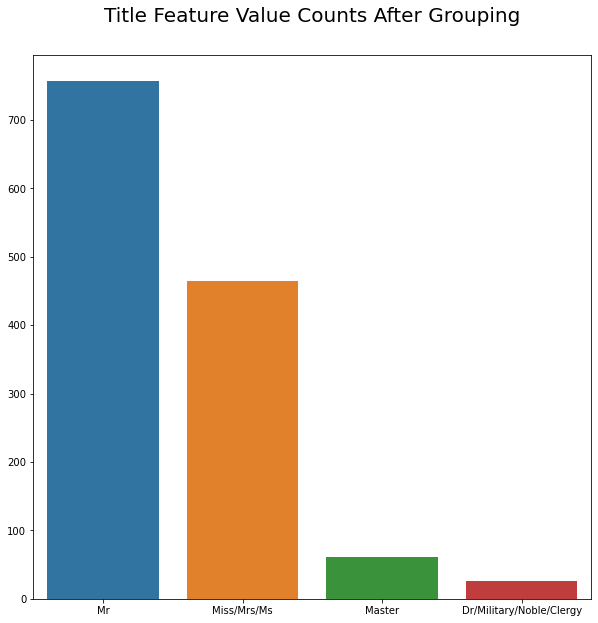

In [36]:
fig = plt.figure(figsize=(10, 10))

# Replace Miss, Mrs, Ms, Mlle, Lady, Mme, the Countess, Dona title as "Miss/Mrs/Ms"
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
# Replace Dr, Col, Major, Jonkheer, Capt, Sir, Don and Rev title as "Dr/Military/Noble/Clergy"
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values)
plt.title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

<a name='3.4'></a>
## 3.4 Feature Transformation
- After modifying all the features into the appropriate forms, we need to encode the categorical features into numerous so that the data is well-prepared for training model.

In [37]:
# Train/Test splitting
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [38]:
df_train.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped,Alone,Ticket_Frequency,Title,Married
0,"(21.0, 22.0]",X,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,small,0,1,Mr,0
1,"(34.0, 40.0]",ABC,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,small,0,2,Miss/Mrs/Ms,1
2,"(25.0, 26.0]",X,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,alone,1,1,Miss/Mrs/Ms,0
3,"(34.0, 40.0]",ABC,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,small,0,2,Miss/Mrs/Ms,1
4,"(34.0, 40.0]",X,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,alone,1,1,Mr,0


<a name='3.4.1'></a>
### 3.4.1 Label encoding non-numerical features
- Norminal data: `Embarked`, `Deck`, `Sex`, `Title`
- Ordinal data: `Family_Size_Grouped`, `Age`, `Fare`

We convert them into numerical data type by using `LabelEncoding`. `LabelEncoding` basically transform categorical value to 0 to n class based on their unique values of each features

Note that:
- **Nominal data** is a type of data that is used as naming or label variables without providing any quantitative value
- **Ordinal data** contains same features as nominal data but plussing the capability of ordered & measured features

In [39]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:
        df[feature] = preprocessing.LabelEncoder().fit_transform(df[feature])

In [40]:
df_train[non_numeric_features]

,Embarked,Sex,Deck,Title,Family_Size_Grouped,Age,Fare
0,2,1,3,3,3,2,0
1,0,0,0,2,3,7,11
2,2,0,3,2,0,4,3
3,2,0,0,2,3,7,10
4,2,1,3,3,0,7,3
...,...,...,...,...,...,...,...
886,2,1,3,0,0,5,5
887,2,0,0,2,0,1,9
888,2,0,3,2,3,2,8
889,0,1,0,3,0,4,9


<a name='3.4.2'></a>
### 3.4.2 One-hot Encoding the categorical features
- We do NOT encode `Family_Size_Grouped`, `Age`, `Fare` feature using One-hot encoder b.c they are ordinal data type
- Because the natural ordering between ordinal categories resulting from One-hot encoding may tend to poor performance or unexpected consequence

In [41]:
cat_features = ['Sex', 'Deck', 'Embarked', 'Title']
# encoded_features: list of encoded df of training & testing dataset
encoded_features = []

# One-hot encoding for both training & testing set
for df in dfs:
    for feature in cat_features:
        # Change to array after encoding b.c want to add columns when change back to df
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        # num of unique value in each feature
        n = df[feature].nunique()
        # "feature_uniqueVal" are the col's names in df after One-hot encoding
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
df_train = pd.concat([df_train, *encoded_features[:4]], axis=1)
df_test = pd.concat([df_test, *encoded_features[4:]], axis=1)

In [42]:
# For submission dataframe
passengerID = df_test['PassengerId']

drop_cols = ['Deck', 'Embarked', 'Family_Size', 'Name', 'Parch', 
             'PassengerId', 'Sex', 'SibSp', 'Ticket', 'Title']

df_train.drop(columns=drop_cols, inplace=True)
drop_cols.append("Survived")
df_test.drop(columns=drop_cols, inplace=True)

In [43]:
df_train.head()

,Age,Fare,Pclass,Survived,Family_Size_Grouped,Alone,Ticket_Frequency,Married,Sex_1,Sex_2,...,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4
0,2,0,3,0.0,3,0,1,0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,7,11,1,1.0,3,0,2,1,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4,3,3,1.0,0,1,1,0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,7,10,1,1.0,3,0,2,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,7,3,3,0.0,0,1,1,0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Conclusion
- `Age` and `Fare` features are binned. Binning features helps dealing with outliers. `Family_size` is created by summing value of `Parch` as number of parent's member, `SibSp` as number of children's member and plussing 1 as him/herself. `Ticket_Frequency` is created by counting the frequency of each unique ticket
- `Name` feature is very useful. First, `Title` and `Is_Married` features are created from the title prefix in the names.
- Finally, the non-numeric type features are label encoded and categorical non-ordinal features are one-hot encoded. Created 5 new features (`Family_Size_Grouped`, `Title`, `Is_Married`, `Deck`, `Ticket_Frequency`) and dropped the useless features after encoding.

<a name='4'></a>
# 4. Modeling
Titanic competition is a binary classification and regression problems. We want to determine the relationship between the features (Age, Fare, Sex,...) and the target column (Survived). Based on the given dataset including this type of problem, a category of machine learning which is called Supervised learning should be useful. Therefore we can narrow down our choice to these below supervised algorithms:
- K-Nearest Neightbors (KNN)
- Support Vector Machines
- Naive Bayes Classifier
- Decision tree
- Random forest
- Extra tree
- Logistic regression
- Stochastic gradient Boosting

In [44]:
X_train = preprocessing.StandardScaler().fit_transform(df_train.drop(['Survived'], axis=1))
y_train = df_train['Survived'].values
X_test = preprocessing.StandardScaler().fit_transform(df_test)

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 20)
y_train shape: (891,)
X_test shape: (418, 20)


<a name='4.1'></a>
## 4.1 Cross validate simple models
The goal of any supervised algorithm is to best optimize the mapping function (f) for
the output variable (Y) with given input data (X)
- In order to create an efficient model, training and testing dataset should comes from different distributions so that the model is capable of adapting to the real-world data
- Therefore, in common cases, the performances on training dataset is largely higher than
those on testing dataset. This problem is called **"Variance error"**

**"K-fold Cross validation"** technique provides a smart move to avoid this problem. It split the training data into k equaled groups & perform the prediction process on 1 group, the other groups are used for training the model. The whole process will be repeatedly carried out for each group & averaging the accuracy of them all to get the final result 

In [45]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

In [46]:
# Cross validate models with K-fold cross validation
Kfold = KFold(n_splits=10, random_state=SEED)

In [47]:
ML_algos = {
    'KNN' : neighbors.KNeighborsClassifier(),
    'SVC' : svm.SVC(probability=True, random_state=SEED),
    'GaussianNB' : naive_bayes.GaussianNB(),
    'DTree' : tree.DecisionTreeClassifier(random_state=SEED),
    'RFor' : ensemble.RandomForestClassifier(random_state=SEED),
    'LReg' : linear_model.LogisticRegressionCV(random_state=SEED),
    'GrB' : ensemble.GradientBoostingClassifier(random_state=SEED),
    'ExTree' : ensemble.ExtraTreesClassifier(random_state=SEED)
}
cv_result = dict()
cv_mean = dict()
cv_std = dict()

# Compute the cross validation result of each ML algorithm
for name, ML_algo in ML_algos.items():
    cv_result[name] = cross_val_score(ML_algo, X_train, y=y_train, scoring='accuracy', cv=Kfold, n_jobs=3)
    cv_mean[name] = cv_result[name].mean()
    cv_std[name] = cv_result[name].std()
    

In [48]:
ML_cv = pd.DataFrame({'cv_mean' : cv_mean, 'cv_std' : cv_std})
ML_cv

,cv_mean,cv_std
KNN,0.813758,0.039216
SVC,0.827154,0.028549
GaussianNB,0.787928,0.038080
DTree,0.804782,0.042873
RFor,0.804719,0.034849
LReg,0.835031,0.040147
GrB,0.840674,0.045240
ExTree,0.803583,0.041241


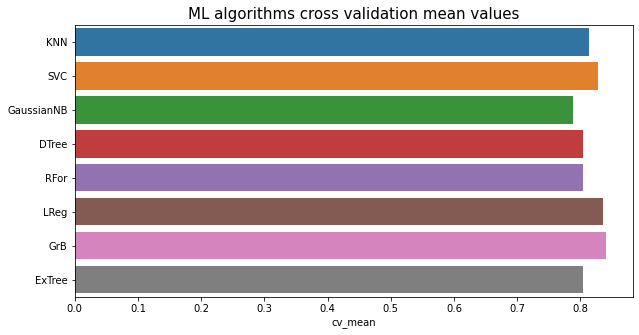

In [49]:
fig = plt.figure(figsize=(10, 5))
ax = sns.barplot(x=ML_cv['cv_mean'], y=ML_cv.index, orient='h')
ax.set_title('ML algorithms cross validation mean values', fontsize=15)
plt.show()

<a name='4.2'></a>
## 4.2 Hyper parameters tuning
- Each model architecture has their own set of parameters which is called "Hyperparameters".
- "Hyperparameters tuning" is a process of constructing clear plan to search for the ideal model architectures by choosing the best options for the their set of parameters 

In [50]:
# Cleaner & greater ways forhyperparameters
# Hyperparameter Tune with GridSearchCV
n_estimators = [10, 50, 100, 300]

grid_param = [
    # KNN 
    {'n_neighbors' : range(1, 31),
     'weights' : ['uniform', 'distance'],
     'metric' : ['euclidean', 'manhattan', 'minkowski']},
    
    # Support vector machine 
    {'kernel' : ['poly', 'rbf', 'sigmoid'],
     'C' : [50, 10, 1.0, 0.1, 0.01], 
     'gamma' : ['scale']},
    
    # Gradient Boosting 
    {'n_estimators' : n_estimators,
     'learning_rate': [0.001, 0.01, 0.1],
     'subsample' : [0.5, 0.7, 1.0],
     'max_depth' : [3, 7, 9] },
    
    # Random forest 
    {'n_estimators' : n_estimators,
    'max_features' : ['sqrt', 'log2'],
    'criterion' : ['gini', 'entropy'],
    'oob_score' : [True]},
    
    # Logistic regression
    {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
     'Cs' : [10, 1.0, 0.1, 0.01],
    'fit_intercept': [True, False]}
]

ML_algos = {
    'KNN' : neighbors.KNeighborsClassifier(),
    'SVC' : svm.SVC(probability=True, random_state=SEED),
    'GrB' : ensemble.GradientBoostingClassifier(random_state=SEED),
    'RFor' : ensemble.RandomForestClassifier(random_state=SEED),
    'LReg' : linear_model.LogisticRegressionCV(random_state=SEED)
}

In [52]:
# Time performance counter
start_time = time.perf_counter()

for param, ML_algo in zip(grid_param, ML_algos.values()):
    # Start counting time
    start = time.perf_counter()
    grid_search = GridSearchCV(estimator = ML_algo, param_grid=param, n_jobs=2, cv=Kfold, 
                               scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_score = grid_result.best_score_
    # Compute time for executing each algo
    run = time.perf_counter() - start
    
    print(f'The best parameter for {ML_algo} is {best_params} with the best accuracy score {best_score}')
    print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')
    ML_algo.set_params(**best_params)

run_total = time.perf_counter() - start_time
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

The best parameter for KNeighborsClassifier() is {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'} with the best accuracy score 0.8328089887640451
Computational runtime of this algo: 9.43 seconds

The best parameter for SVC(probability=True, random_state=42) is {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} with the best accuracy score 0.8294132334581772
Computational runtime of this algo: 7.13 seconds

The best parameter for GradientBoostingClassifier(random_state=42) is {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} with the best accuracy score 0.8406741573033708
Computational runtime of this algo: 298.91 seconds

The best parameter for RandomForestClassifier(random_state=42) is {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 50, 'oob_score': True} with the best accuracy score 0.8103370786516854
Computational runtime of this algo: 32.98 seconds

The best parameter for LogisticRegressionCV(random_state=42) is {'Cs': 10, 'fit

<a name='4.3'></a>
## 4.3 Confusion matrix
- Confusion matrix is a table describing the performance measurement of ML classification problems. The technique is performed on the set of validation data for which the true values are known

<img src="images/confusion_matrix.png" style="width:300px;height:200px;">

For those who confuse, the "positive" or "negative" depends on the purpose of the model. This model is used to predict the survival passengers --> "positive" means predict 1 as Survived & "negative" means predict 0 as not survived
- **True positive (TP)**: "True" means the prediction value is similar to the actual value AND "positive" means models predict 1 as a survived passenger
- **True negative (TN)**: "True" means the prediction value is similar to the actual value AND "negative" means models predict 0 as a non-survived passenger
- **False negative (FN)**: "False" means the prediction value is different from the actual values AND "negative" means models predict 0 as a non-survived passenger
- **False positive (FN)**: "False" means the prediction value is different from the actual values AND "positive" means models predict 1 as a survived passenger

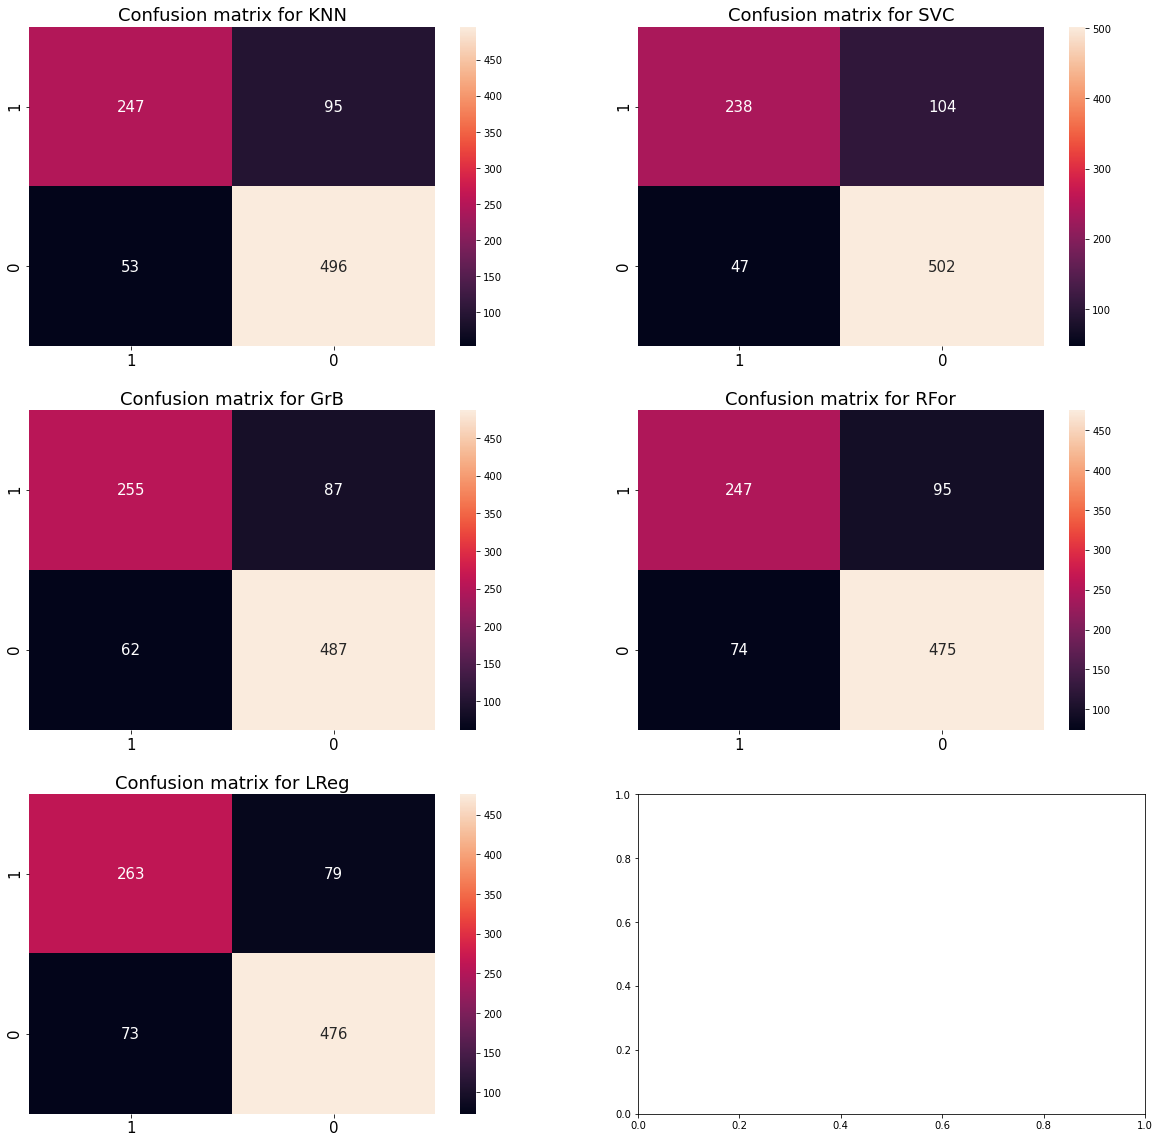

In [53]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
axs = axs.flatten()

i = 0
for name, model in ML_algos.items():
    y_pred = cross_val_predict(model, X_train, y_train, cv=10)
    # Plotting the confusion matrix
    sns.heatmap(np.flip(confusion_matrix(y_train, y_pred)), ax=axs[i], annot=True, fmt='2.0f', 
               annot_kws={"size":15})
    axs[i].set_xticklabels(['1', '0'], fontsize=15)
    axs[i].set_yticklabels(['1', '0'], fontsize=15)
    axs[i].set_title(f"Confusion matrix for {name}", fontsize=18)
    i += 1
plt.show()

<a name='4.4'></a>
## 4.4 Ensemble model
- The voting classifier can be a good choice to combine the predictions coming from the 5 classifiers.

In [55]:
voteC = ensemble.VotingClassifier(estimators=[('KNN_best', ML_algos['KNN']), ('SVC_best', ML_algos['SVC']),
                                             ('GrB_best', ML_algos['GrB']), ('RFor_best', ML_algos['RFor']),
                                             ('LReg_best', ML_algos['LReg'])],
                                 voting='soft', n_jobs=4)
voteC = voteC.fit(X_train, y_train)

<a name='4.5'></a>
## 4.5 Submission

In [57]:
# Making the prediction
y_pred = voteC.predict(X_test)

submission = pd.DataFrame({
        'PassengerId' : passengerID,
        'Survived' : y_pred.astype(int)})

# submission.to_csv('output/submission.csv', index=False)

## Credit & Resource
- Credit should be extended for [Anisotropic](https://www.kaggle.com/arthurtok) and [Gunes Evitan](https://www.kaggle.com/gunesevitan) and all super surportive Kaggler. Send a big thanks to all of them!
- To [Dataquest](https://www.dataquest.io/?utm_source=google&utm_medium=cpc&utm_campaign&matchtype=e&device=c&campaignid=2083591861&adgroupid=75850930719&adid=482446438765&gclid=CjwKCAjwxo6IBhBKEiwAXSYBs5UgtShJIv7wWV0xdKvnKNUbQ-YyWCpZoUMlTh4fEpyhjU6ButFI0RoCMRAQAvD_BwE) where I start my journey
- To [Coursera](https://www.coursera.org/) that provided me fundamental skills to get my feets wet
<br>

**Some great resource:**
- For excellent materials on stacking or ensembling model, refers to a must-read article for all Kagglers [Kaggle Ensembling Guide](https://mlwave.com/kaggle-ensembling-guide/)
- [Introduction to machine learning with Python: A Guide to data scientist](https://www.amazon.com/gp/product/1449369413/ref=as_li_tl?ie=UTF8&tag=kaggle-20&camp=1789&creative=9325&linkCode=as2&creativeASIN=1449369413&linkId=740510c3199892cca1632fe738fb8d08) written by core creators of sklearn
- [Machine learning online course](https://www.coursera.org/learn/machine-learning?) hosted by Andrew Ng _ a pioneer in online education especially on ML & AI

### If you find this notebook is helpful, please do the upvote and/or leave a comment!! 